In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# from sklearn.gaussian_process import GaussianProcess

# subroutines

In [95]:
## diversity
def shannon(oneD_array, total=100):
    shannon = 0
    for item in oneD_array:
        if item != 0:
            if total == 100:
                item = item / 100.0
                
            shannon += item * np.log(item)
    shannon *= -1
    shannon = round(shannon, 5)
    return shannon

# test_profile = pd.read_table('C:\Users\pengye\Desktop\\tmp\\annotated.mOTU.abundances.original')
# shannon(test_profile.ix[:, 1])

## get df of a specific taxo level
def taxoLevel(profile, level, data='df'):
    """
    PROFILE should be a DataFrame or a Series (indicates by key word DATA), by default, data == 'df' (DataFrame)
    
    LEVEL indicates which level of taxonomy profile you want to get
    for instance, 
        >>> taxoLevel(df_profile_with_month.ix[:2, :], 'k', 'df')
    gives you,
        >>>
            	k__Archaea	k__Bacteria	k__Eukaryota	k__Viruses
            10_12M	0	100.0000	0	0.0000
            10_20150812	0	99.9958	0	0.0042
    """
    result = pd.DataFrame()
    if data=='df':
        for item in profile.columns:
            short = item.split('|')[-1].split('__')[0]
            if short == level:
                result[item] = pd.to_numeric(profile[item])
        # result = result.to_numeric
        
    else:
        result = pd.Series()
        for item in profile.index:
            short = item.split('|')[-1].split('__')[0]
            if short == level:
                result[item] = profile[item]
        result = pd.to_numeric(result)
    return result

# data

## loading

In [146]:
df_age = pd.DataFrame.from_csv('C:\Users\pengye\Desktop\infantGMG\data\\758sample.age.csv', sep='\t')
df_rxn = pd.DataFrame.from_csv('C:\Users\pengye\Desktop\infantGMG\data\\758.sample.rxn.profile', sep='\t').T
df_motu = pd.DataFrame.from_csv('C:\Users\pengye\Desktop\infantGMG\data\\758.sample.mOTU.profile', sep='\t').T
df_ko = pd.DataFrame.from_csv('C:\Users\pengye\Desktop\infantGMG\data\\758.sample.ko.profile', sep='\t').T
df_go = pd.DataFrame.from_csv('C:\Users\pengye\Desktop\infantGMG\data\\758.sample.go.profile', sep='\t').T
df_ec = pd.DataFrame.from_csv('C:\Users\pengye\Desktop\infantGMG\data\\758.sample.ec.profile', sep='\t').T
df_pwy = pd.DataFrame.from_csv('C:\Users\pengye\Desktop\infantGMG\data\\758.sample.pwy.profile', sep='\t').T
df_bug = pd.DataFrame.from_csv('C:\Users\pengye\Desktop\infantGMG\data\\all.798.bug.profile_newCol.txt', sep='\t').T

# df_gf = pd.DataFrame.from_csv('C:\Users\pengye\Desktop\infantGMG\data\\758.sample.genefamilies.profile', sep='\t')
# this file is too big, and it takes too much memory, so it will be processed especially later.

In [174]:
df_bug_s = taxoLevel(df_bug, 's', data='df')
list_bug_spec_div = [shannon(df_bug_s.ix[i, :]) for i in range(len(df_bug_s.index))]
df_bug['spec_diversity'] = list_bug_spec_div

list_rxn_div = [shannon(df_rxn.ix[i, :], total=1) for i in range(len(df_rxn.index))]
df_rxn['rxn_diversity'] = list_rxn_div

list_motu_div = [shannon(df_motu.ix[i, :], total=1) for i in range(len(df_motu.index))]
df_motu['motu_diversity'] = list_motu_div

list_ko_div = [shannon(df_ko.ix[i, :], total=1) for i in range(len(df_ko.index))]
df_ko['ko_diversity'] = list_ko_div

list_go_div = [shannon(df_go.ix[i, :], total=1) for i in range(len(df_go.index))]
df_go['go_diversity'] = list_go_div

list_ec_div = [shannon(df_ec.ix[i, :], total=1) for i in range(len(df_ec.index))]
df_ec['ec_diversity'] = list_ec_div

list_pwy_div = [shannon(df_pwy.ix[i, :], total=1) for i in range(len(df_pwy.index))]
df_pwy['pwy_diversity'] = list_pwy_div

In [175]:
df_all_but_gf = pd.concat([df_rxn, df_ko, df_go, df_ec, df_pwy, df_motu, df_bug], axis=1, join='inner')
# df_all_but_gf.ix[750, 0] /df_all_but_gf.ix[:, 0].max()

In [237]:
# 739 smpl, both included in df_age and df_profile
list_age_and_profile = list(set(df_age.index) & set(df_all_but_gf.index))
df_age_739 = df_age.ix[list_age_and_profile]
df_all_but_gf_739 = df_all_but_gf.ix[list_age_and_profile]

In [385]:
# 721 smpl, select from 739 smpl with age less than or equal to 36 months
df_age_721_le36 = df_age_739[df_age_739['month'] <= 36]
df_all_but_gf_721 = df_all_but_gf.ix[df_age_721_le36.index]

## scaling with MinMaxScaler

In [154]:
from sklearn.preprocessing import MinMaxScaler

In [386]:
ndarray_all_but_gf_scaled_721 = MinMaxScaler().fit_transform(df_all_but_gf_721)
df_all_but_gf_scaled_721 = pd.DataFrame(ndarray_all_but_gf_scaled_721)

df_all_but_gf_scaled_721.columns = df_all_but_gf_721.columns # just don't wanna convert df into ndarray (for later regression part, so...)
df_all_but_gf_scaled_721.index = df_all_but_gf_721.index

# feature selection

## by variance

In [236]:
from sklearn.feature_selection import VarianceThreshold 
# not used

In [387]:
all_721_profile_std = df_all_but_gf_721.describe().ix['std']

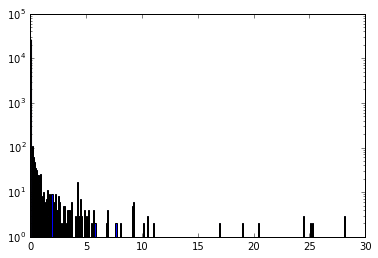

count    2.624300e+04
mean     6.219746e-02
std      7.978214e-01
min      0.000000e+00
25%      3.154496e-08
50%      1.302367e-05
75%      8.622541e-05
max      2.819701e+01
Name: std, dtype: float64

In [388]:
## not scaled
%matplotlib inline
plt.xlim(0,30)
plt.yscale('log')
plt.hist(all_721_profile_std, bins=300)
plt.show()
all_721_profile_std.describe()

In [389]:
all_721_profile_scaled_std = df_all_but_gf_scaled_721.describe().ix['std']

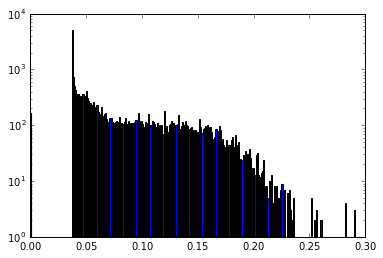

count    26243.000000
mean         0.081838
std          0.048028
min          0.000000
25%          0.039877
50%          0.062194
75%          0.116838
max          0.290830
Name: std, dtype: float64

In [390]:
## scaled
%matplotlib inline
plt.xlim(0,0.3)
plt.yscale('log')
plt.hist(all_721_profile_scaled_std, bins=300)
plt.show()
all_721_profile_scaled_std.describe()

In [391]:
sr_std_721_profile_scaled_ge_75 = all_721_profile_scaled_std[all_721_profile_scaled_std >= all_721_profile_scaled_std.quantile(.75)]

## by correlation coefficient

In [393]:
sr_corr_month_and_profile = df_all_but_gf_scaled_721.corrwith(df_age_721_le36['month'])
sr_corr_day_and_profile = df_all_but_gf_scaled_721.corrwith(df_age_721_le36['days'])

count    26080.000000
mean        -0.059992
std          0.193688
min         -0.600615
25%         -0.161922
50%         -0.030127
75%          0.051585
max          0.616142
dtype: float64

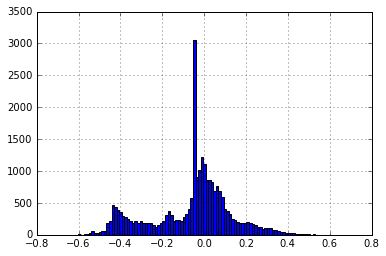

In [394]:
%matplotlib inline
sr_corr_month_and_profile.hist(bins=100)
sr_corr_month_and_profile.describe()

count    26077.000000
mean        -0.059909
std          0.191939
min         -0.603802
25%         -0.161417
50%         -0.029767
75%          0.051055
max          0.609562
dtype: float64

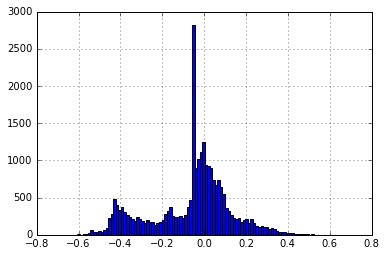

In [395]:
sr_corr_day_and_profile.hist(bins=100)
sr_corr_day_and_profile.describe()

In [397]:
sr_corr_month_abs_ge_03 = sr_corr_month_and_profile[sr_corr_month_and_profile**2>=0.09]
sr_corr_day_abs_ge_03 = sr_corr_day_and_profile[sr_corr_day_and_profile**2>=0.09]

print 'Union:', len(set(sr_corr_month_abs_ge_03.index) | set(sr_corr_day_abs_ge_03.index))
print 'Symmetric Difference:', len(set(sr_corr_month_abs_ge_03.index) ^ set(sr_corr_day_abs_ge_03.index))

Union: 4946
Symmetric Difference: 171


## select according to variance (ge 75%) and corr (abs ge 0.2, union)

In [398]:
list_abs_ge_03_union_d_m = list(set(sr_corr_month_abs_ge_03.index) | set(sr_corr_day_abs_ge_03.index))

In [399]:
set_q75 = set(sr_std_721_profile_scaled_ge_75.index)
set_c03 = set(list_abs_ge_03_union_d_m)
print len(set_q75 - set_c03)
print len(set_c03 - set_q75)
print len(set_c03 & set_q75)

3102
1487
3459


In [353]:
import pip

def install(package):
   pip.main(['install', package])
# install('matplotlib-venn')

In [358]:
from matplotlib_venn import venn2

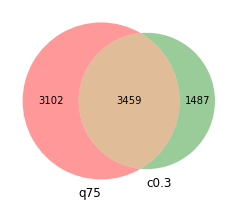

In [400]:
%matplotlib inline
plt.figure(figsize=(4, 4))
venn2(subsets=(3102, 1487, 3459), set_labels=('q75', 'c0.3'))
plt.show()

In [402]:
list_c03_d_m_AND_q75 = list(set_c03 & set_q75)

In [403]:
df_all_but_gf_scaled_721_c03_d_m_AND_q75 = df_all_but_gf_scaled_721[list_c03_d_m_AND_q75]

## select using RF

In [375]:
from sklearn.ensemble import RandomForestRegressor as rfr

In [411]:
X = df_all_but_gf_scaled_721_c03_d_m_AND_q75
y = df_age_721_le36['month']

In [412]:
regr_rf = rfr(max_depth=30, random_state=2)
regr_rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

Feature ranking:
1. feature 3145 (0.324601), 0.324601
2. feature 2924 (0.106592), 0.431193
3. feature 680 (0.065907), 0.497100
4. feature 122 (0.052073), 0.549173
5. feature 145 (0.028395), 0.577569
6. feature 2283 (0.025500), 0.603068
7. feature 2365 (0.016707), 0.619775
8. feature 61 (0.016529), 0.636304
9. feature 2756 (0.011292), 0.647596
10. feature 1222 (0.008805), 0.656401
11. feature 32 (0.008488), 0.664889
12. feature 3073 (0.005531), 0.670419
13. feature 490 (0.005221), 0.675641
14. feature 2264 (0.004805), 0.680446
15. feature 708 (0.004686), 0.685132
16. feature 2728 (0.004640), 0.689771
17. feature 1345 (0.004632), 0.694403
18. feature 3284 (0.004618), 0.699021
19. feature 387 (0.004548), 0.703569
20. feature 1088 (0.004348), 0.707917
21. feature 2032 (0.004321), 0.712238
22. feature 1232 (0.004048), 0.716286
23. feature 1432 (0.004017), 0.720302
24. feature 2727 (0.003417), 0.723719
25. feature 1454 (0.003340), 0.727059
26. feature 1935 (0.003078), 0.730137
27. feature 20

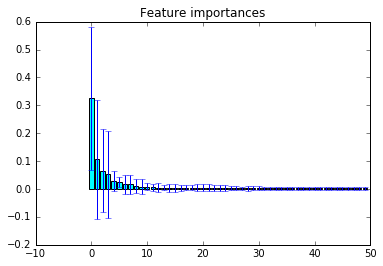

In [433]:
# pd.Series(regr_rf.feature_importances_).plot()

importances = regr_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

list_idx = []
cumsum = 0
for f in range(X.shape[1]):
    cumsum += float(importances[indices[f]])
    list_idx.append(indices[f])
    print("%d. feature %d (%f), %f" % (f + 1, indices[f], importances[indices[f]], cumsum))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")

plt.bar(range(50), importances[indices[:50]],
       color="cyan", yerr=std[indices[:50]], align="center")

# plt.bar(range(X.shape[1]), importances[indices],
#       color="cyan", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.show()

In [482]:
from sklearn.cross_validation import cross_val_score

In [498]:
y = df_age_721_le36['month']
tmp_regr_rf = rfr(max_depth=30, random_state=2)

idx = []
dict_score = {}
dict_score_mean = {}
dict_residual = {}

for i, id_ in enumerate(list_idx):
    idx.append(id_)
    x = df_all_but_gf_scaled_721_c03_d_m_AND_q75.ix[:, idx]
    tmp_regr_rf.fit(x, y)
    y_predict = tmp_regr_rf.predict(x)
    residual = y_predict - y
    residual = residual ** 2
    
    dict_score[i+1] = tmp_regr_rf.score(x, y)
    dict_score_mean[i+1] = cross_val_score(tmp_regr_rf, x, y).mean()
    dict_residual[i+1] = residual.sum()
    
    # print 'Processing feature %d' % i
    if i == 100:
         break
    

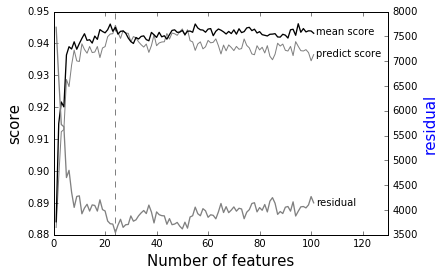

In [648]:
df_score_residual = pd.DataFrame([dict_score, dict_score_mean, dict_residual], index=['score', 'cross_val_score_mean', 'residual'])

ax = plt.gca()
ax.plot(df_score_residual.ix['score'], c='grey', linestyle='-', linewidth=1)
ax.set_ylabel('score', color='k', fontsize=15)

ax1 = ax.twinx()
ax1.plot(df_score_residual.ix['cross_val_score_mean'], c='k', linewidth=1.3)
ax1.set_yticklabels([])
ax1.set_yticks([])
# ax1.set_ylabel('', color='grey')

ax2 = ax.twinx()
ax2.plot(df_score_residual.ix['residual'], c='gray', linestyle='-', linewidth=1.3)
ax2.set_ylabel('residual', color='b', fontsize=15)

ax.axvline(24, c='gray', linestyle='--')
ax.set_xlabel('Number of features', fontsize=15)

plt.xlim(xmax=130)
ax.text(.785, .9, 'mean score', transform=ax.transAxes, color='k')
ax.text(.785, .8, 'predict score', transform=ax.transAxes, color='k')
ax.text(.785, .13, 'residual', transform=ax.transAxes, color='k')

In [659]:
list_24_f_loc = list_idx[:24]

df_all_but_gf_scaled_721__c03_d_m_AND_q75__rf_24 = df_all_but_gf_scaled_721_c03_d_m_AND_q75.ix[:, list_24_f_loc]
list_24_f_names = list(df_all_but_gf_scaled_721_c03_d_m_AND_q75.ix[:, list_24_f].columns)

In [660]:
list_24_f_names

['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium',
 '4.2.1.31',
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii',
 'K03294',
 'METH-ACETATE-PWY:methanogenesisfromacetate',
 'GO:0005315:MF:04:inorganic phosphate transmembrane transporter activity',
 'K02035',
 'COMPLETE-ARO-PWY:superpathwayofaromaticaminoacidbiosynthesis',
 '3.1.3.18',
 'K18220',
 'K02529',
 'K07160',
 'K01886',
 'K00356',
 '3.1.3.48',
 '3.2.1.93',
 'K01753',
 'K08972',
 'BIS5-ADENOSYL-TRIPHOSPHATASE-RXN',
 '2.8.1.2',
 'K05812',
 '1.5.1.39',
 '5.3.1.3']

# model construction

In [645]:
x_24 = df_all_but_gf_scaled_721__c03_d_m_AND_q75__rf_24
y = df_age_721_le36['month']

regr_rf_24 = rfr(max_depth=30, random_state=2)
regr_rf_24.fit(x_24, y)
y_24 = regr_rf_24.predict(x_24)

corr_y__y_24 = np.corrcoef(list(y), list(y_24))[0, 1]

score_24 = regr_rf_24.score(x_24, y)
cross_val_24_mean = cross_val_score(regr_rf_24, x_24, y).mean()

In [704]:
## subroutine for plotting
def plotScatter(y_true, y_predict, title):
    ax = plt.gca()
    ax.scatter(y_predict, y_true, c='grey', edgecolors='grey', alpha=.6)
    ax.set_xticklabels(['', 0, 5, 10, 15, 20, 25, 30, 35])
    ax.set_yticklabels(['', 0, 5, 10, 15, 20, 25, 30, 35])
    ax.set_xlabel('True month of age', fontsize=12)
    ax.set_ylabel('Predicted month of age', fontsize=13)
    ax.set_title(title, fontsize=15)
    
    corr_ = np.corrcoef(list(y_true), list(y_predict))[0, 1]
    ax.text(0, 35, "Pearson's $R^2$ = %.3f" % corr_**2, fontsize=10)
    
    ax1 = ax.twinx()
    ax1.plot((-.5, 36), (-.5, 36), c='k')
    ax1.set_yticklabels([])
    ax1.set_yticks([])

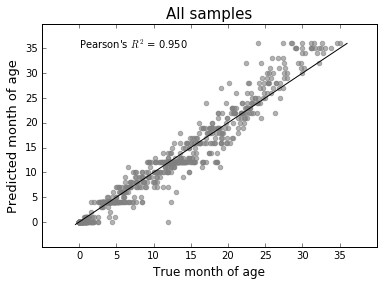

In [705]:
plotScatter(y, y_24, 'All samples')

## standard

## train_test

In [654]:
from sklearn.cross_validation import train_test_split

In [687]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(x_24, y,
                                                   train_size=505, # test_size = 216
                                                   random_state=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(x_24, y,
                                                   train_size=505, # test_size = 216
                                                   random_state=2)

X_train3, X_test3, y_train3, y_test3 = train_test_split(x_24, y,
                                                   train_size=505, # test_size = 216
                                                   random_state=3)

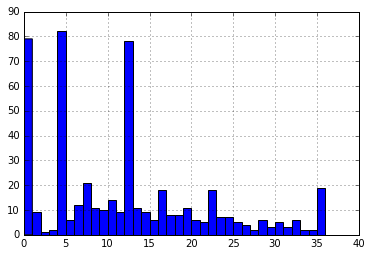

In [739]:
y_train1.hist(bins=36)

In [697]:
regr_rf_subtest_1 = rfr(max_depth=30, random_state=2)
regr_rf_subtest_1.fit(X_train1, y_train1)

y_rf_train1 = regr_rf_subtest_1.predict(X_train1)
y_rf_test1 = regr_rf_subtest_1.predict(X_test1)

In [698]:
regr_rf_subtest_2 = rfr(max_depth=30, random_state=2)
regr_rf_subtest_2.fit(X_train2, y_train2)

y_rf_train2 = regr_rf_subtest_2.predict(X_train2)
y_rf_test2 = regr_rf_subtest_2.predict(X_test2)

In [699]:
regr_rf_subtest_3 = rfr(max_depth=30, random_state=2)
regr_rf_subtest_3.fit(X_train3, y_train3)

y_rf_train3 = regr_rf_subtest_3.predict(X_train3)
y_rf_test3 = regr_rf_subtest_3.predict(X_test3)

In [694]:
# from sklearn.metrics import roc_curve, auc
# STUPID!! This only works for classification

### Training_test 1

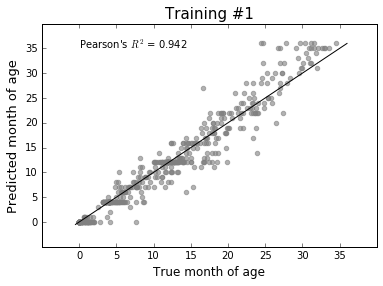

In [706]:
plotScatter(y_train1, y_rf_train1, 'Training #1')

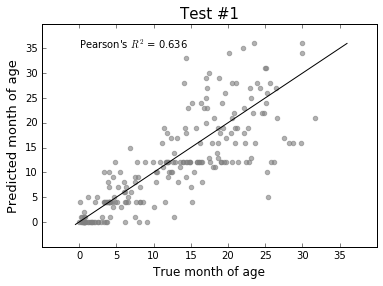

In [707]:
plotScatter(y_test1, y_rf_test1, 'Test #1')

### Training_test 2

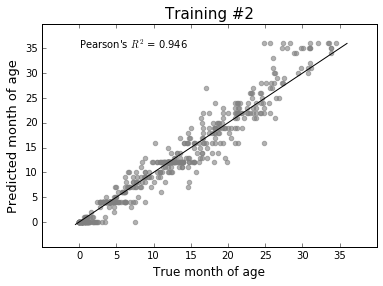

In [709]:
plotScatter(y_train2, y_rf_train2, 'Training #2')

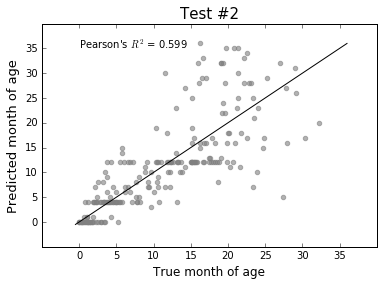

In [711]:
plotScatter(y_test2, y_rf_test2, 'Test #2')

### Training_test 3

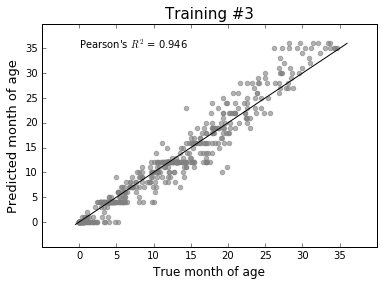

In [710]:
plotScatter(y_train3, y_rf_train3, 'Training #3')

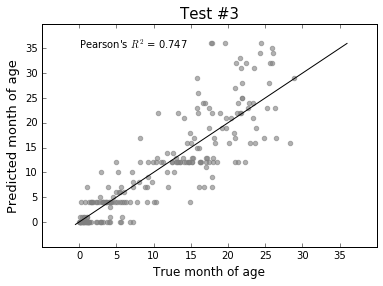

In [712]:
plotScatter(y_test3, y_rf_test3, 'Test #3')

### Average of 3

In [731]:
ave_3_test_predict_y = np.median([y_rf_test1, y_rf_test2, y_rf_test3], axis=0)
ave_3_test_true_y = np.median([y_test1, y_test2, y_test3], axis=0)

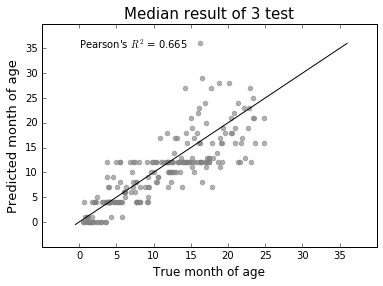

In [735]:
plotScatter(ave_3_test_true_y, ave_3_test_predict_y, 'Median result of 3 test')

In [733]:
ave_3_train_predict_y = np.median([y_rf_train1, y_rf_train2, y_rf_train3], axis=0)
ave_3_train_true_y = np.median([y_train1, y_train2, y_train3], axis=0)

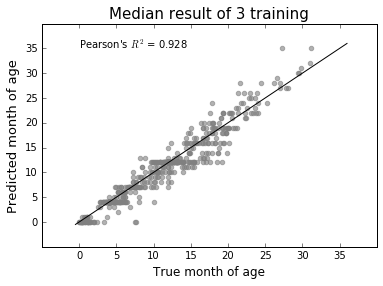

In [736]:
plotScatter(ave_3_train_true_y, ave_3_train_predict_y, 'Median result of 3 training')